# TIPS

## This notebook shows the example for one image only

### Imports and functions

Please follow the installation guide before you run the following cells.

In [129]:
#!pip install mediapy
#!pip install tensorflow_text
#!pip install jax

In [130]:
import glob
import io
import os
import mediapy as media
import numpy as np
from PIL import Image
from PIL import Image
import tensorflow_text
from tips.pytorch import image_encoder
from tips.pytorch import text_encoder
from tips.scenic.utils import feature_viz
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

IMAGE_MEAN = (0, 0, 0)
IMAGE_STD = (1.0, 1.0, 1.0)
PATCH_SIZE = 14
MAX_LEN = 64
VOCAB_SIZE = 32000


def load_image_bytes(file_name):
  with open(file_name, 'rb') as fd:
    image_bytes = io.BytesIO(fd.read())
    pil_image = Image.open(image_bytes)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
    input_tensor = transform(pil_image)
    input_batch = input_tensor.unsqueeze(0)

  return input_batch

### Configure the TIPS model.

In [131]:
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']

# Add your images in this directory.
image_dir = 'images/inputs/basketball/color/'  # @param {type: "string"}
image_paths = glob.glob(os.path.join(image_dir, '*'))[:1]
# The text inputs to be contrasted.
text_inputs = [
    'A ship',
    'A lion',
    'a toy',
    'Seven Cats',
    'A laptop',
    'a cat',
    'a starry night',
    'A president',
]


In [132]:

# Add the checkpoints and tokenizer path.
image_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_vision.npz'  # @param {type: "string"}
text_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_text.npz'  # @param {type: "string"}
tokenizer_path = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tokenizer.model'  # @param {type: "string"}

### Run Vision Encoder Inference.

In [133]:
# Load checkpoint.
weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []

with torch.no_grad():
  # Load the vision encoder.
  model_image = image_encoder.vit_small(
      img_size=image_size,
      patch_size=PATCH_SIZE,
      ffn_layer=ffn_layer,
      block_chunks=0,
      init_values=1.0,
      interpolate_antialias=True,
      interpolate_offset=0.0,
  )
  model_image.load_state_dict(weights_image)

  for image_path in image_paths:
    input_batch = load_image_bytes(image_path)
    output = model_image(input_batch)
    cls_token = feature_viz.normalize(
        output[0][0][0]
    )  # Choose the first CLS token.
    spatial_feature = torch.reshape(
        output[2],
        (1, int(image_size / PATCH_SIZE), int(image_size / PATCH_SIZE), -1),
    )
    spatial_features.append(spatial_feature)
    embeddings_image.append(cls_token)

In [134]:
embeddings_image[0].shape

torch.Size([384])

## Tips Image Decoder - Depth estimation

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging

class DepthDecoderFromEmbedding(nn.Module):
    """
    Decoder that converts TIPS image embeddings into a dense depth prediction.
    Accepts spatial features [B, H, W, D] and optional CLS token [D].
    """
    def __init__(self, embedding_dim=384, num_bins=256, upsample_factor=4):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_bins = num_bins
        self.upsample_factor = upsample_factor

        self.linear_head = nn.Conv2d(embedding_dim, num_bins, kernel_size=1)

        logging.info(f"Initialized DepthDecoderFromEmbedding: "
                     f"embedding_dim={embedding_dim}, bins={num_bins}, upsample x{upsample_factor}")

    def forward(self, spatial_feature, cls_token=None):
        """
        Args:
            spatial_feature: torch.Tensor [B, H, W, D]
            cls_token: torch.Tensor [D] (optional)
        Returns:
            depth: torch.Tensor [B, H*upsample, W*upsample]
            logits: torch.Tensor [B, bins, H*upsample, W*upsample]
        """
        try:
            logging.info(f"Input spatial feature shape: {spatial_feature.shape}")
            B, H, W, D = spatial_feature.shape
            x = spatial_feature.permute(0, 3, 1, 2)  # [B, D, H, W]
            logging.info(f"Permuted to channels-first: {x.shape}")

            if cls_token is not None:
                if cls_token.ndim == 1:
                    cls_token = cls_token.unsqueeze(0).unsqueeze(2).unsqueeze(3)  # [1, D, 1, 1]
                elif cls_token.ndim == 2:
                    cls_token = cls_token.unsqueeze(2).unsqueeze(3)
                logging.info(f"CLS token shape for fusion: {cls_token.shape}")
                x = x + cls_token  # Broadcast addition

            x = F.interpolate(x, scale_factor=self.upsample_factor, mode='bilinear', align_corners=False)
            logging.info(f"Upsampled features: {x.shape}")

            logits = self.linear_head(x)
            logging.info(f"Logits shape: {logits.shape}")

            probs = torch.softmax(logits, dim=1)
            bin_centers = torch.linspace(0.1, 10.0, self.num_bins, device=logits.device).view(1, self.num_bins, 1, 1)
            depth = torch.sum(probs * bin_centers, dim=1)

            logging.info(f"Predicted depth shape: {depth.shape}")
            return depth, logits

        except Exception as e:
            logging.error(f"Error in forward pass: {e}")
            return None, None


In [136]:
decoder = DepthDecoderFromEmbedding()

# Inputs from your TIPs model
spatial_feature = spatial_features[0]  # [1, 32, 32, 384]
cls_token = embeddings_image[0]        # [384]

# Forward pass
predicted_depth, logits = decoder(spatial_feature, cls_token)

print("Output depth shape:", predicted_depth.shape)


INFO:root:Initialized DepthDecoderFromEmbedding: embedding_dim=384, bins=256, upsample x4
INFO:root:Input spatial feature shape: torch.Size([1, 32, 32, 384])
INFO:root:Permuted to channels-first: torch.Size([1, 384, 32, 32])
INFO:root:CLS token shape for fusion: torch.Size([1, 384, 1, 1])
INFO:root:Upsampled features: torch.Size([1, 384, 128, 128])
INFO:root:Logits shape: torch.Size([1, 256, 128, 128])
INFO:root:Predicted depth shape: torch.Size([1, 128, 128])


Output depth shape: torch.Size([1, 128, 128])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_depth_map(depth_tensor: torch.Tensor, cmap='gray_r'):
    """
    Visualizes a single depth map tensor using matplotlib.

    """
    # Remove batch dimension if needed
    if depth_tensor.ndim == 3:
        depth_tensor = depth_tensor.squeeze(0)

    depth_np = depth_tensor.detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(depth_np, cmap=cmap)
    plt.colorbar(label='Depth (meters)')
    plt.title('Predicted Depth Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


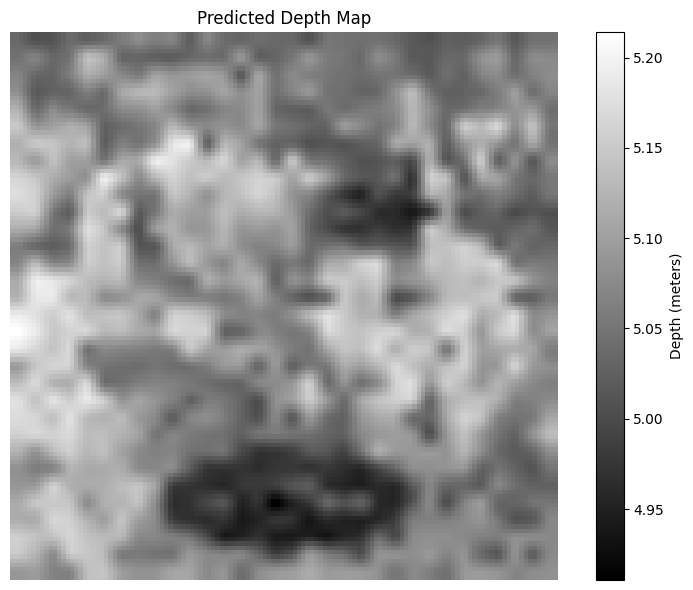

In [138]:
visualize_depth_map(predicted_depth)

In [139]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Run Text Encoder Inference.

In [ ]:
def get_text_config(v):
  return {
      'hidden_size': {'S': 384, 'B': 768, 'L': 1024, 'So400m': 1152, 'g': 1536}[
          v
      ],
      'mlp_dim': {'S': 1536, 'B': 3072, 'L': 4096, 'So400m': 4304, 'g': 6144}[
          v
      ],
      'num_heads': {'S': 6, 'B': 12, 'L': 16, 'So400m': 16, 'g': 24}[v],
      'num_layers': {'S': 12, 'B': 12, 'L': 12, 'So400m': 27, 'g': 12}[v],
  }


with open(text_encoder_checkpoint, 'rb') as fin:
  inbuffer = io.BytesIO(fin.read())
np_weights_text = np.load(inbuffer, allow_pickle=False)

weights_text = {}
for key, value in np_weights_text.items():
  weights_text[key] = torch.from_numpy(value)

temperature = weights_text.pop('temperature')
with torch.no_grad():
  # Load the text encoder.
  model_text = text_encoder.TextEncoder(
      get_text_config(variant),
      vocab_size=VOCAB_SIZE,
  )
  model_text.load_state_dict(weights_text)
  tokenizer = text_encoder.Tokenizer(tokenizer_path)

  text_ids, text_paddings = tokenizer.tokenize(text_inputs, max_len=MAX_LEN)
  embeddings_text = model_text(
      torch.from_numpy(text_ids), torch.from_numpy(text_paddings)
  )
  embeddings_text = feature_viz.normalize(embeddings_text)

I0000 00:00:1742936815.100072 3656556 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 26406 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:83:00.0, compute capability: 7.5
I0000 00:00:1742936815.101754 3656556 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47192 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:84:00.0, compute capability: 7.5
I0000 00:00:1742936815.103698 3656556 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9620 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
I0000 00:00:1742936815.105683 3656556 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9620 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:03:00.0, compute capability: 7.5


## Visualize the results.

In [ ]:
len(embeddings_image[0])

384

In [ ]:
embeddings_image

[tensor([ 1.0359e-01, -8.9150e-03,  2.8407e-02,  5.8511e-02, -2.2732e-02,
         -5.4739e-02,  7.7514e-02, -4.8358e-02, -7.8461e-03, -6.4083e-03,
          6.0356e-02, -1.3755e-02, -3.5715e-02,  8.0023e-02,  7.7965e-02,
          1.3102e-02, -4.1080e-02, -4.4627e-02,  2.4683e-02, -1.1090e-02,
         -6.3740e-02, -4.1932e-02,  3.0328e-02, -7.2208e-02, -1.6959e-02,
         -2.8084e-02,  9.7183e-03, -1.4758e-02, -6.6067e-03,  1.0488e-01,
         -3.2889e-02, -7.8971e-02,  8.5410e-03,  1.0262e-02,  6.4781e-02,
         -3.8564e-02, -4.5832e-02,  1.8237e-02, -7.5705e-04,  3.5262e-02,
         -6.3041e-02, -4.5894e-02,  9.7074e-02,  3.0468e-03,  9.1270e-04,
         -9.9479e-03, -1.8693e-02,  2.6086e-02, -2.4936e-02,  6.4872e-02,
         -6.8106e-02, -1.7146e-02,  4.0039e-02, -3.1830e-02,  5.6350e-02,
          1.1842e-02,  5.4023e-02, -2.8884e-02,  3.1852e-02,  1.0441e-01,
          4.5946e-02, -1.8664e-02,  4.8261e-02, -2.7075e-02, -3.5440e-02,
          5.4768e-02, -2.7722e-02,  2.

Input image,"a starry night, prob: 43.0%"

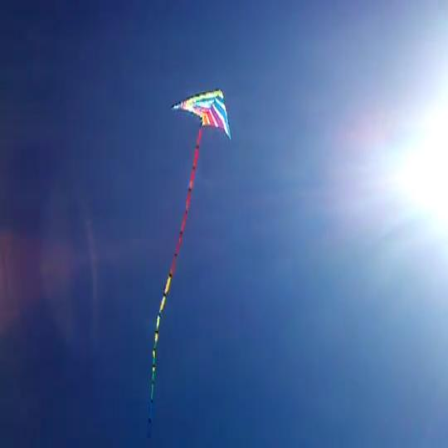
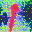

In [ ]:
for idx, embedding_image in enumerate(embeddings_image):
  # Compute cosine similariy.
  cos_sim = F.softmax(
      ((embedding_image.unsqueeze(0) @ embeddings_text.T) / temperature), dim=-1
  )
  label_idxs = torch.argmax(cos_sim, axis=-1)
  cos_sim_max = torch.max(cos_sim, axis=-1)
  label_predicted = text_inputs[label_idxs[0]]
  similarity = cos_sim_max.values[0]

  # Visualize the results.
  pca_obj = feature_viz.PCAVisualizer(spatial_features[idx])
  image_pca = pca_obj(spatial_features[idx])[0]

  with open(image_paths[idx], 'rb') as f:
    image = Image.open(f)
    image = image.resize((image_size, image_size), Image.Resampling.BILINEAR)
    image = np.array(image).astype(np.float32) / 255.0

  media.show_images(
      [image, image_pca],
      width=image_size,
      titles=[
          'Input image',
          f'{label_predicted},  prob: {similarity*100:.1f}%',
      ],
  )

In [ ]:
#!pip install timm

In [ ]:
#### Extracting attention maps from the model
# How the output of the image encoder change as we use other text inputs.

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Generate video from images

In [6]:
import cv2
import os
import glob

def create_video_from_images(image_folder, output_video, fps=10):
    # Get all image files in the folder
    images = sorted(glob.glob(os.path.join(image_folder, "*.png")))

    if not images:
        print(f"No images found in the specified folder: {image_folder}")
        return

    print(f"Found {len(images)} images.")

    # Read the first image to get dimensions
    frame = cv2.imread(images[0])
    if frame is None:
        print("Error: Could not read the first image.")
        return
    
    height, width, _ = frame.shape
    print(f"Video dimensions: {width}x{height}")

    # Ensure output directory exists
    output_dir = os.path.dirname(output_video)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    if not out.isOpened():
        print("Error: VideoWriter failed to open.")
        return

    for img_path in images:
        frame = cv2.imread(img_path)
        if frame is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        out.write(frame)  # Write frame to video

    out.release()
    print(f"Video saved as {output_video}")

# Example usage
file = "squirrel"
image_folder = f"/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/outputs/{file}/depth/"  # Replace with your folder path
output_video = f"/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/outputs/videos/{file}_depth_video.mp4"  # Desired output video filename

create_video_from_images(image_folder, output_video)


Found 3131 images.
Video dimensions: 256x256
Video saved as /usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/images/outputs/videos/squirrel_depth_video.mp4
